In [129]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [130]:
def f(x):
    return 3*x**2 - 4*x + 5

In [131]:
f(3.0)

20.0

In [132]:
xs  = np.arange(-20, 20, 1)
ys = f(xs)

In [133]:
xs,ys

(array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
          6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19]),
 array([1285, 1164, 1049,  940,  837,  740,  649,  564,  485,  412,  345,
         284,  229,  180,  137,  100,   69,   44,   25,   12,    5,    4,
           9,   20,   37,   60,   89,  124,  165,  212,  265,  324,  389,
         460,  537,  620,  709,  804,  905, 1012]))

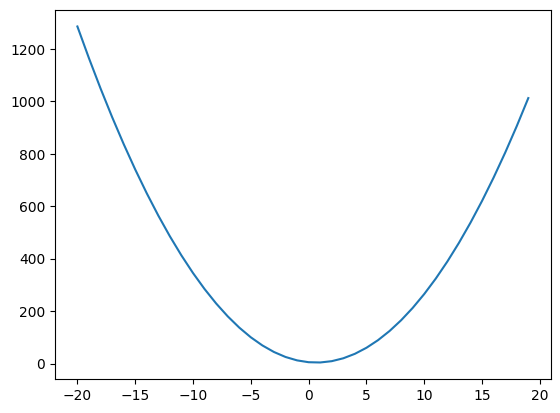

In [134]:
plt.plot(xs, ys)

In [135]:
h = 0.001
x = -3.0
f(x+h) 

43.978003

In [136]:
(f(x+h) - f(x))/h

-21.996999999998934

In [137]:
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
d

4.0

In [138]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a*b+c
d2 = (a+h)*(b)+c
print("d1-",d1,"d2-", d2)
print("slope", (d2-d1)/h)


d1- 4.0 d2- 3.999699999999999
slope -3.000000000010772


In [151]:
class Value:
    def __init__(self, data, _children=() , _op='',label = ''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda : None
        self._op = _op
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other),'+')
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data , (self, other),'*')
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self.__mul__(other)
    
    
    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        n = self.data
        e = math.exp(n)
        out = Value(e,(self,),'exp')
        def _backward():
            self.grad += e*out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0        
        for node in reversed(topo):
            node._backward()



a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b ; e.label = 'e'
d = e+c;d.label = 'd'
f = Value(-2.0, label='f')
L = d*f;L.label = 'L'


In [140]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    # builds a set of nodes and edges in the graph
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir':'LR'})
    # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph ,create a rectangular node
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f }"%(n.label,n.data , n.grad),shape='record')
        
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot


In [141]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights w1,w2
w1 = Value(-3.0 , label='w1')
w2 = Value(1.0 , label='w2')
# bias
b = Value(6.8813 , label='b')

x2w2 = x2*w2 ; x2w2.label = 'x2*w2'
x1w1 = x1*w1 ; x1w1.label = 'x1*w1'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh();o.label = 'o'




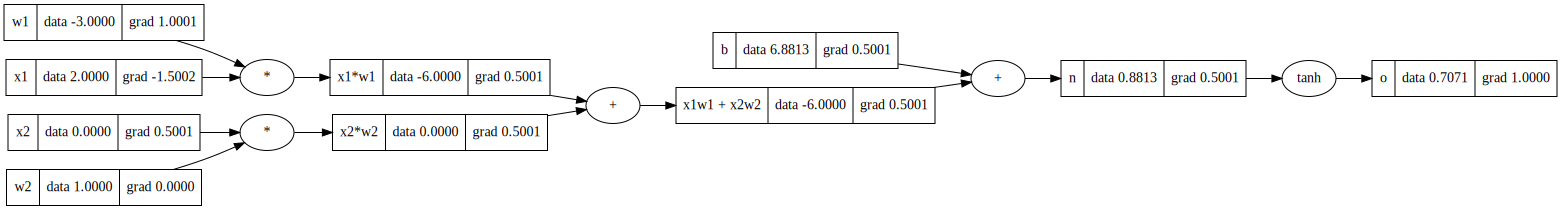

In [142]:
o.backward()
draw_dot(o)

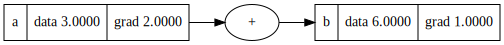

In [143]:
a = Value(3.0, label='a')
b = a+a ; b.label = 'b'
b.backward()
draw_dot(b)

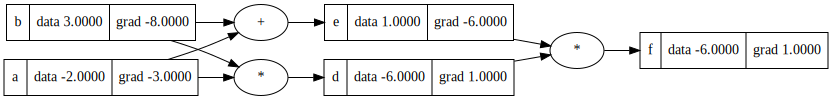

In [144]:
a=Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b ; d.label = 'd'
e = a+b ; e.label = 'e'
f = d*e ; f.label = 'f'
f.backward()
draw_dot(f)